# DS-поток, весна 2025
## Задание ADL.1


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарииь к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Баллы за задание**  
Задача 1 &mdash; **90 баллов**  
Задача 2 &mdash; **30 баллов**

Всего &mdash; **120 баллов**  

In [1]:
# Bot check

# HW_ID: ds_adl1
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [35]:
import numpy as np
import pandas as pd
import time
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from functools import lru_cache
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision import transforms

## Задача 1 &mdash; обучение моделей на разном объеме данных

В этой задаче нужно определить зависимость качества модели от размера обучающих данных и сравнить между собой сверточную и трансформерную модель.

В качестве данных будем использовать [датасет](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset) с фотографиями одежды и аксессуаров. В качестве лейблов классификации используем поле `subCategory` в `styles`.

### 1. Подготовка данных



In [ ]:
# Если нужно распаковать zip
import zipfile
zip_file_path = <...>
extract_to_directory = '.'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    for file in tqdm(file_list, desc="Extracting files", unit="files"):
        zip_ref.extract(file, extract_to_directory)

Для начала определим пути до изображений и таблицы с описанием товаров.

In [3]:
root = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
images_root = root / 'images'
styles_path = root / 'styles.csv'

Считаем таблицу с описанием товаров. Заметим, что нас интересует только одна колонка &mdash; `subCategory`.

In [4]:
styles_df = pd.read_csv(styles_path, usecols=['id', 'subCategory'], index_col='id')
styles_df.head()

,subCategory
id,
15970,Topwear
39386,Bottomwear
59263,Watches
21379,Bottomwear
53759,Topwear


Заметим, что количество изображений близко, но не точно равно количеству товаров в таблице с описанием.

In [5]:
len(list(images_root.iterdir())), len(styles_df)

(44441, 44446)

При этом идентификаторы изображений уникальны, а среди идентификаторов в таблице с описанием есть несколько повторений.

In [6]:
ids1 = [int(path.name.split('.')[0]) for path in images_root.iterdir()]
ids2 = styles_df.index.tolist()
print(len(set(ids1) & set(ids2)) == len(ids1))

True


Посчитаем количество различных лейблов.

In [7]:
labels = styles_df.loc[ids1]['subCategory'].values
val, cnt = np.unique(labels, return_counts=True)
cnt

array([  143,   106,  3055,    12,     4,   811,  2693,   108,   478,
          43,  1073,   915,  1012,   104,    20,    19,   293,     1,
        1808,  1080,   527,   470,   307,    38,   329,     6,   963,
         427,   118,    24,  7344,    69,    77,   698,     3,    21,
          90,   258, 15401,     6,     1,   933,  2542,     7,     4])

Отсечем все классы, которые встречаются слишком редко &mdash; меньше 100 экземпляров. Для них оставим соответствующие идентификаторы. Визуализируем некоторые картинки.

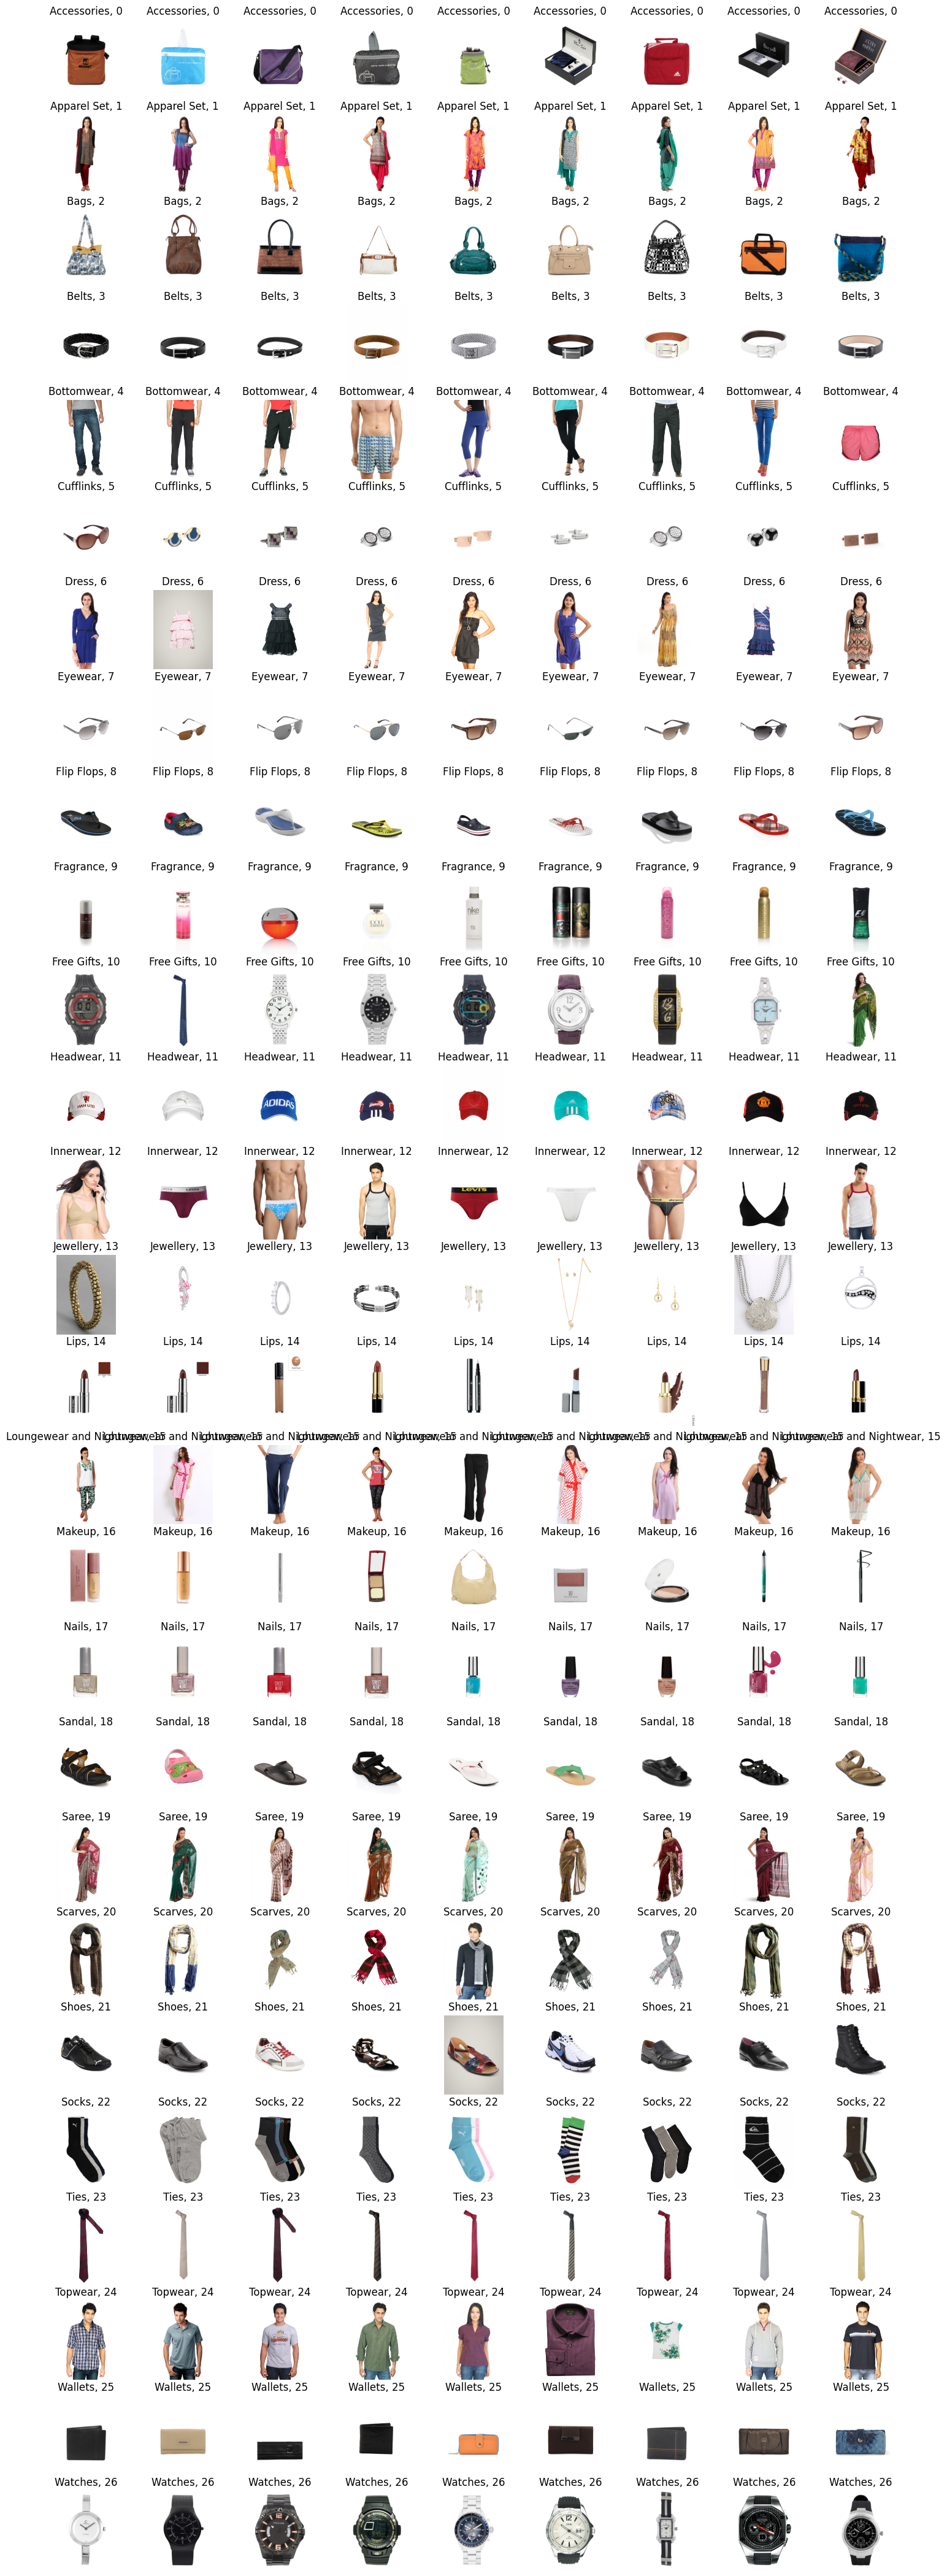

In [8]:
labels_unique = val[cnt >= 100]
len(labels_unique)

fig, axs = plt.subplots(27, 9, figsize=(18, 54))
for i, label in enumerate(labels_unique):
    ids = styles_df[styles_df['subCategory'] == label].index[:9]
    for j, id in enumerate(ids):
        image = Image.open(images_root / f'{id}.jpg')
        axs[i, j].imshow(image)
        axs[i, j].set_title(f"{label}, {i}")
        axs[i, j].axis('off')

Можно заметить, что есть классы товаров, которые могут включать в себя другие классы товаров.

In [9]:
labels = styles_df["subCategory"][styles_df["subCategory"].isin(labels_unique)]
val, cnt = np.unique(labels, return_counts=True)
for v, c in zip(val, cnt):
    print(v, c)

Accessories 143
Apparel Set 106
Bags 3055
Belts 811
Bottomwear 2694
Cufflinks 108
Dress 478
Eyewear 1073
Flip Flops 915
Fragrance 1012
Free Gifts 104
Headwear 293
Innerwear 1808
Jewellery 1080
Lips 527
Loungewear and Nightwear 470
Makeup 307
Nails 329
Sandal 963
Saree 427
Scarves 118
Shoes 7344
Socks 698
Ties 258
Topwear 15405
Wallets 933
Watches 2542


Категория `Accessories` довольно общая, но при этом немногочисленная, ее можно исключить. То же касается категории `Free Gifts`. Категории `Flip Flops` и `Sandal` значительно пересекаются друг с другом, поэтому их лучше объединить.

In [10]:
labels_unique = labels_unique[~np.isin(labels_unique, ["Accessories",  "Free Gifts", "Flip Flops"])]
styles_df[styles_df["subCategory"] == "Flip Flops"] = "Sandal"
styles_df = styles_df[styles_df["subCategory"].isin(labels_unique)]
num_classes, num_ids = len(labels_unique), len(styles_df.index)
num_classes, num_ids

(24, 43754)

Составим карту отображения лейблов в классы.

In [11]:
label2class = {label: i for i, label in enumerate(labels_unique)}
label2class

{'Apparel Set': 0,
 'Bags': 1,
 'Belts': 2,
 'Bottomwear': 3,
 'Cufflinks': 4,
 'Dress': 5,
 'Eyewear': 6,
 'Fragrance': 7,
 'Headwear': 8,
 'Innerwear': 9,
 'Jewellery': 10,
 'Lips': 11,
 'Loungewear and Nightwear': 12,
 'Makeup': 13,
 'Nails': 14,
 'Sandal': 15,
 'Saree': 16,
 'Scarves': 17,
 'Shoes': 18,
 'Socks': 19,
 'Ties': 20,
 'Topwear': 21,
 'Wallets': 22,
 'Watches': 23}

Проверим, для всех ли идентификаторов из таблицы стилей есть соответствующие изображения. Удалим идентификаторы, для которых изображения не нашлись.

In [12]:
not_found_ids = []
for id in tqdm(styles_df.index):
    if not (images_root / f'{id}.jpg').exists():
        not_found_ids.append(id)
styles_df = styles_df[~styles_df.index.isin(not_found_ids)]

# Проверим, что в таблице остались только уникальные идентификаторы.
assert len(styles_df.index) == len(np.unique(styles_df.index))

  0%|          | 0/43754 [00:00<?, ?it/s]

Реализуем класс для работы с данными.

In [27]:
class StylesDataset(Dataset):
    def __init__(self, images_root, styles_df, label2class, ids, transform):
        self.images_root = images_root
        self.styles_df = styles_df
        self.label2class = label2class
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    @lru_cache(maxsize=400)
    def __getitem__(self, i):
        id = self.ids[i]
        image = Image.open(self.images_root / f'{id}.jpg')
        image = self.transform(image)
        label = self.styles_df.loc[id, 'subCategory']
        cls = self.label2class[label]
        return image, cls

Доопределим ids

In [26]:
ids = styles_df.index

In [38]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

if torch.cuda.device_count() > 1:
    print("Используем", torch.cuda.device_count(), "GPU")

Device: cuda:0
Используем 2 GPU


### 2. Обучение моделей

Модели можно выбрать из [timm](https://github.com/huggingface/pytorch-image-models), [torchvision](https://pytorch.org/vision/stable/models.html) или [huggingface](https://huggingface.co/docs/transformers/index). В качестве сверточной модели можно использовать EfficientNet или более мощную модель. Более мощную модель будем определять по рейтингу top-1 моделей предобученных на ImageNet. Для сравнения моделей можно воспользоваться [рейтингом paperswithcode](https://paperswithcode.com/sota/image-classification-on-imagenet) или соотвествующими результатами в научных статьях, посвященным моделям для классификации изображений. В качестве трансформерной модели можно использовать ViT, DeiT, CeiT, VOLO, SWIN или более мощные модели. Для того, чтобы достигнуть хорошего качества, используйте уже предобученные модели.

*Задача*  &mdash;  для разных обучающих наборов данных: 2000, 8000 снимков и всего набора данных (42749 снимков) посчитайте weighted accuracy (усредненную accuracy по всем классам) для сверточной и трансформерной моделей. На тест выделите 1000 снимков. На большом объеме данных трансформерная модель не должна быть сильно хуже сверточной. На всем датасете обе модели должны пробить порог weighted accuracy равный 0.8.

Возможно, *для улучшения качества трансформера* вам могут помочь:
- [пример](https://keras.io/examples/vision/vit_small_ds/) с построением трансформерной модели на keras, где описываются аугментации, shifted patches, local attention;
- [статья](https://arxiv.org/pdf/2106.03746.pdf), где используют доп. лосс для обучения произвольной трансформерной модели на небольшом объеме данных.

*Правила проведения экспериментов*.
- Для всех экспериментов используйте одинаковый пайплайн семплирования данных &mdash; аугментации, размер батча, метод выбора данных для формирования батча.
- Для экспериментов с одинаковым количеством обучающих данных используйте одинакове число эпох для обучения. 
- Для каждой модели (сверточной и трансформерной) зафиксируйте пайплайн обучения &mdash; саму модель, оптимизатор, learing rate scheduling, регуляризацию весов модели, лоссы.
- Поясните выбор стратегии семплирования данных и пайпайна обучения.

In [69]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_splits(ids, test_size=1000, train_valid_size=2000, random_state=42):
    """
    Генерирует честное разделение данных на train, valid и test выборки.
    
    Параметры:
        ids (list/pd.Series): Полный список идентификаторов
        test_size (int): Размер тестовой выборки (по умолчанию 1000)
        train_valid_size (int): Общий размер train+valid выборки (по умолчанию 2000)
        random_state (int): Seed для воспроизводимости
        
    Возвращает:
        train_ids, valid_ids, test_ids: Разделенные списки идентификаторов
    """
    total_needed = test_size + train_valid_size
    if len(ids) < total_needed:
        raise ValueError(f"Недостаточно данных. Всего {len(ids)}, требуется {total_needed}")
    
    remaining_ids, test_ids = train_test_split(
        ids, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    train_ids, valid_ids = train_test_split(
        remaining_ids,
        train_size=int(train_valid_size * 0.8),
        test_size=int(train_valid_size * 0.2),
        random_state=random_state,
        shuffle=True
    )
    
    return train_ids, valid_ids, test_ids

def weighted_accuracy(preds, y, num_classes):
    """
    Вычисляет усредненную точность по классам.
    preds: логиты модели, размер [batch_size, num_classes]
    y: истинные метки (целые числа)
    num_classes: общее число классов
    """
    _, predicted = torch.max(preds, 1)
    class_accuracies = []
    for c in range(num_classes):
        idx = (y == c)
        if idx.sum() == 0:
            continue
        class_acc = (predicted[idx] == y[idx]).float().mean().item()
        class_accuracies.append(class_acc)
    return sum(class_accuracies) / len(class_accuracies) if class_accuracies else 0.0

def train_epoch(model, iterator, optimizer, criterion, num_classes, device):
    """Исправлено: удален loss_history из параметров"""
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:  # Убрал tqdm для чистоты вывода
        optimizer.zero_grad()
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        acc = weighted_accuracy(predictions, labels, num_classes)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)  # Умножаем на размер батча
        epoch_acc += acc * images.size(0)  # Взвешенное суммирование

    return epoch_loss / len(iterator.dataset), epoch_acc / len(iterator.dataset)

def evaluate_epoch(model, iterator, criterion, num_classes, device):
    """Исправлено: удален loss_history"""
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)
            acc = weighted_accuracy(predictions, labels, num_classes)
            
            epoch_loss += loss.item() * images.size(0)
            epoch_acc += acc * images.size(0)

    return epoch_loss / len(iterator.dataset), epoch_acc / len(iterator.dataset)

def train_model(model, train_loader, valid_loader, test_loader, optimizer, criterion, 
                num_classes, device, epochs=10, model_name='model'):
    history = {'train_loss': [], 'train_acc': [], 
               'valid_loss': [], 'valid_acc': [],
               'test_loss': None, 'test_acc': None}
    
    for epoch in tqdm(range(epochs), leave=False):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, num_classes, device)
        valid_loss, valid_acc = evaluate_epoch(model, valid_loader, criterion, num_classes, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        
        epoch_time = time.time() - start_time
        print(f"{model_name} | Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}\n")
    
    test_loss, test_acc = evaluate_epoch(model, test_loader, criterion, num_classes, device)
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    print(f"Test Acc: {test_acc:.4f}")
    
    return model, history

def get_dataloaders(images_root, styles_df, label2class, train_ids,
                    valid_ids, train_transform, valid_transform, batch_size):
    train_dataset = StylesDataset(images_root, styles_df,
                                  label2class, train_ids, train_transform)
    valid_dataset = StylesDataset(images_root, styles_df,
                                  label2class, valid_ids, valid_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, valid_loader

def run_experiment(train_ids, valid_ids, test_ids,
                   num_classes, device, batch_size, epochs=10):
    train_loader, valid_loader = get_dataloaders(images_root, styles_df, label2class,
                                                 train_ids, valid_ids, train_transform,
                                                 valid_transform, batch_size)
    test_dataset = StylesDataset(images_root, styles_df, label2class, test_ids, transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    conv_model = timm.create_model('tf_efficientnet_b0', pretrained=True, num_classes=num_classes)
    conv_model = conv_model.to(device)
    conv_model = nn.DataParallel(conv_model)

    transformer_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    transformer_model = transformer_model.to(device)
    transformer_model = nn.DataParallel(transformer_model)

    conv_optimizer = optim.AdamW(conv_model.parameters(), lr=1e-4, weight_decay=1e-4)
    transformer_optimizer = optim.AdamW(transformer_model.parameters(), lr=5e-5, weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()

    conv_model, conv_history = train_model(
        conv_model, train_loader, valid_loader, test_loader,
        conv_optimizer, criterion, num_classes, device, epochs, 'EfficientNet'
    )
    
    transformer_model, transformer_history = train_model(
        transformer_model, train_loader, valid_loader, test_loader,
        transformer_optimizer, criterion, num_classes, device, epochs, 'ViT'
    )
    
    return conv_model, transformer_model, conv_history, transformer_history

Аугментации

In [59]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

num_classes = max(label2class.values()) + 1

batch_size = 32

Запуск обучения

In [70]:
train_ids, valid_ids, test_ids = generate_splits(
    ids, 
    test_size=1000, 
    train_valid_size=2000,
    random_state=42
)

conv_model_2000, vit_model_2000, conv_hist_2000, vit_hist_2000 = run_experiment(
    train_ids, valid_ids, test_ids, num_classes, device, batch_size, epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

EfficientNet | Epoch 1/5 | Time: 33.07s
Train Loss: 1.7160 | Train Acc: 0.3406
Valid Loss: 0.7930 | Valid Acc: 0.6872

EfficientNet | Epoch 2/5 | Time: 32.94s
Train Loss: 0.7168 | Train Acc: 0.6796
Valid Loss: 0.3952 | Valid Acc: 0.8321

EfficientNet | Epoch 3/5 | Time: 32.93s
Train Loss: 0.3807 | Train Acc: 0.8419
Valid Loss: 0.2703 | Valid Acc: 0.8895

EfficientNet | Epoch 4/5 | Time: 32.94s
Train Loss: 0.2518 | Train Acc: 0.8808
Valid Loss: 0.2227 | Valid Acc: 0.9186

EfficientNet | Epoch 5/5 | Time: 32.39s
Train Loss: 0.1923 | Train Acc: 0.9172
Valid Loss: 0.1929 | Valid Acc: 0.9317

Test Acc: 0.8727


  0%|          | 0/5 [00:00<?, ?it/s]

ViT | Epoch 1/5 | Time: 40.84s
Train Loss: 0.7479 | Train Acc: 0.6852
Valid Loss: 0.2511 | Valid Acc: 0.8826

ViT | Epoch 2/5 | Time: 40.48s
Train Loss: 0.1338 | Train Acc: 0.9324
Valid Loss: 0.1646 | Valid Acc: 0.9111

ViT | Epoch 3/5 | Time: 40.13s
Train Loss: 0.0675 | Train Acc: 0.9735
Valid Loss: 0.1909 | Valid Acc: 0.9404

ViT | Epoch 4/5 | Time: 40.96s
Train Loss: 0.0251 | Train Acc: 0.9836
Valid Loss: 0.1653 | Valid Acc: 0.9371

ViT | Epoch 5/5 | Time: 40.99s
Train Loss: 0.0412 | Train Acc: 0.9832
Valid Loss: 0.2468 | Valid Acc: 0.9165

Test Acc: 0.8844


In [71]:
clear_memory()

In [72]:
train_ids, valid_ids, test_ids = generate_splits(
    ids, 
    test_size=1000, 
    train_valid_size=8000,
    random_state=42
)

conv_model_8000, vit_model_8000, conv_hist_8000, vit_hist_8000 = run_experiment(
    train_ids, valid_ids, test_ids, num_classes, device, batch_size, epochs=3
)

  0%|          | 0/3 [00:00<?, ?it/s]

EfficientNet | Epoch 1/3 | Time: 128.99s
Train Loss: 0.9051 | Train Acc: 0.6293
Valid Loss: 0.2817 | Valid Acc: 0.8680

EfficientNet | Epoch 2/3 | Time: 127.60s
Train Loss: 0.2535 | Train Acc: 0.8874
Valid Loss: 0.2294 | Valid Acc: 0.9103

EfficientNet | Epoch 3/3 | Time: 126.61s
Train Loss: 0.1490 | Train Acc: 0.9340
Valid Loss: 0.1362 | Valid Acc: 0.9452

Test Acc: 0.9363


  0%|          | 0/3 [00:00<?, ?it/s]

ViT | Epoch 1/3 | Time: 152.05s
Train Loss: 0.3895 | Train Acc: 0.8317
Valid Loss: 0.2670 | Valid Acc: 0.8967

ViT | Epoch 2/3 | Time: 152.78s
Train Loss: 0.1250 | Train Acc: 0.9434
Valid Loss: 0.1672 | Valid Acc: 0.9268

ViT | Epoch 3/3 | Time: 152.54s
Train Loss: 0.0675 | Train Acc: 0.9642
Valid Loss: 0.1544 | Valid Acc: 0.9275

Test Acc: 0.9220


In [73]:
train_ids, valid_ids, test_ids = generate_splits(
    ids, 
    test_size=1000, 
    train_valid_size=40000,
    random_state=42
)

conv_model_40000, vit_model_40000, conv_hist_40000, vit_hist_40000 = run_experiment(
    train_ids, valid_ids, test_ids, num_classes, device, batch_size, epochs=1
)

  0%|          | 0/1 [00:00<?, ?it/s]

EfficientNet | Epoch 1/1 | Time: 645.04s
Train Loss: 0.3230 | Train Acc: 0.8605
Valid Loss: 0.1328 | Valid Acc: 0.9552

Test Acc: 0.9650


  0%|          | 0/1 [00:00<?, ?it/s]

ViT | Epoch 1/1 | Time: 751.93s
Train Loss: 0.1869 | Train Acc: 0.9123
Valid Loss: 0.1530 | Valid Acc: 0.9252

Test Acc: 0.9243


Графики обучения

In [85]:
def plot_histories(histories, title):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    color_map = plt.get_cmap('tab10')
    
    idx = 0
    for model_type, sizes in histories.items():
        for size, hist in sizes.items():
            label_base = f'{model_type} {size}'
            color = color_map(idx)
            idx += 1

            if len(hist['train_loss']) == 1:
                ax[0].plot(hist['train_loss'], label=f'{label_base} Train',
                       color=color, marker='o')
                ax[0].plot(hist['valid_loss'], label=f'{label_base} Valid',
                       color=color, marker='x')
            
                ax[1].plot(hist['train_acc'], label=f'{label_base} Train',
                       color=color, marker='o')
                ax[1].plot(hist['valid_acc'], label=f'{label_base} Valid',
                       color=color, marker='x')
            else:
                ax[0].plot(hist['train_loss'], label=f'{label_base} Train',
                       color=color, linestyle='-')
                ax[0].plot(hist['valid_loss'], label=f'{label_base} Valid',
                       color=color, linestyle='--')
            
                ax[1].plot(hist['train_acc'], label=f'{label_base} Train',
                       color=color, linestyle='-')
                ax[1].plot(hist['valid_acc'], label=f'{label_base} Valid',
                       color=color, linestyle='--')
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    for a in ax:
        a.legend()
        a.grid()
    plt.suptitle(title)
    plt.show()

Визуализация

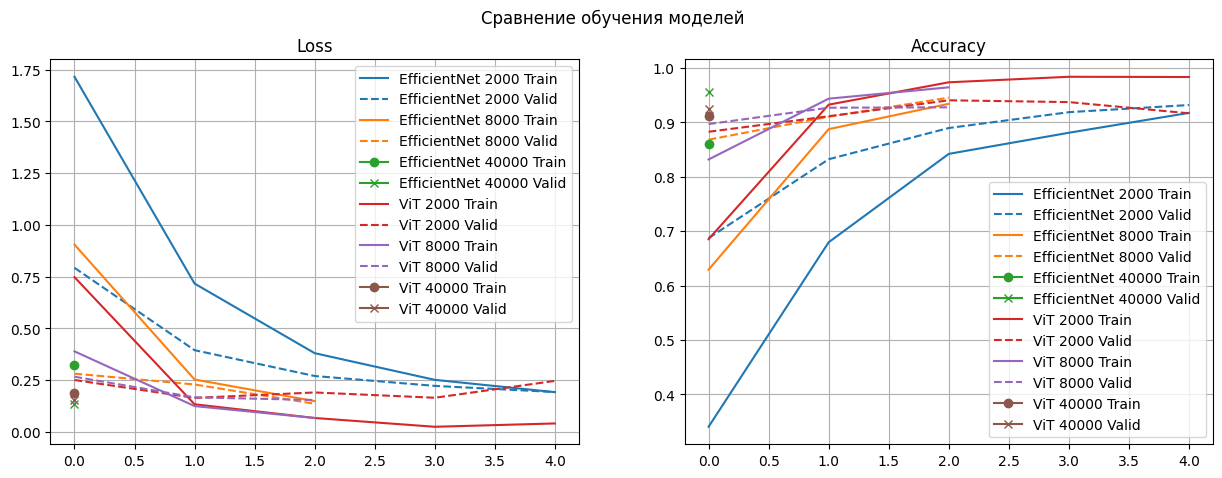

In [86]:
histories = {
    'EfficientNet': {
        2000: conv_hist_2000,
        8000: conv_hist_8000,
        40000: conv_hist_40000
    },
    'ViT': {
        2000: vit_hist_2000,
        8000: vit_hist_8000,
        40000: vit_hist_40000
    }
}
plot_histories(histories, 'Сравнение обучения моделей')

### 3. Анализ моделей

1. Оцените размеры моделей (MB). Сравните время вычислений (сек.) и затрачиваемую память (MB) на обучении и на инференсе для обеих моделей.

In [93]:
import copy

def get_model_size_mb(model):
    """
    Рассчитывает полный размер модели (параметры + буферы) в мегабайтах.
    """
    total_bytes = 0
    
    for param in model.parameters():
        total_bytes += param.element_size() * param.nelement()
    
    for buffer in model.buffers():
        total_bytes += buffer.element_size() * buffer.nelement()
    
    return total_bytes / (1024 ** 2)

def benchmark_inference(model, test_loader, device, num_batches=100):
    model.eval().to(device)
    times = []
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            images = images.to(device)
            
            start = time.time()
            _ = model(images)
            torch.cuda.synchronize()
            times.append(time.time() - start)
    
    avg_time = sum(times) / len(times)
    peak_mem = torch.cuda.max_memory_allocated() / (1024 ** 2) if torch.cuda.is_available() else 0
    
    return {
        'inference_time': avg_time,
        'inference_memory': peak_mem
    }

def benchmark_train(model, train_loader, optimizer, criterion, device, num_batches=100):
    """Обучение на N батчах с замером метрик"""
    model = copy.deepcopy(model).to(device)
    model.train()
    
    metrics = {
        'total_time': 0.0,
        'time_per_batch': [],
        'memory_usage': []
    }
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    progress = tqdm(total=num_batches, desc=f"Training {model.__class__.__name__}", leave=False)
    
    for i, (images, labels) in enumerate(train_loader):
        if i >= num_batches:
            break
            
        images, labels = images.to(device), labels.to(device)
        
        start_time = time.time()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        torch.cuda.synchronize()
        batch_time = time.time() - start_time
        
        if torch.cuda.is_available():
            mem_usage = torch.cuda.max_memory_allocated() / (1024 ** 2)
        else:
            mem_usage = 0
        
        metrics['total_time'] += batch_time
        metrics['time_per_batch'].append(batch_time)
        metrics['memory_usage'].append(mem_usage)
        
        progress.update(1)
        progress.set_postfix({
            'time': f"{batch_time:.3f}s",
            'mem': f"{mem_usage:.1f}MB"
        })
    
    progress.close()
    
    metrics['avg_time_per_batch'] = sum(metrics['time_per_batch']) / num_batches
    metrics['peak_memory'] = max(metrics['memory_usage'])
    
    return metrics

Запустим подсчет и посмотрим на результаты

In [95]:
results = []
sizes = [2000, 8000, 40000]

for size in tqdm(sizes):
    conv_model = globals()[f'conv_model_{size}']
    conv_hist = globals()[f'conv_hist_{size}']
    
    vit_model = globals()[f'vit_model_{size}']
    vit_hist = globals()[f'vit_hist_{size}']
    
    for model, hist, name in tqdm([(conv_model, conv_hist, 'EfficientNet'),
                              (vit_model, vit_hist, 'ViT')]):
        
        model_size = get_model_size_mb(model)
        
        inference_stats = benchmark_inference(model, test_loader, device)

        optimizer = optim.AdamW(model.parameters(), lr=1e-5)
        criterion = nn.CrossEntropyLoss()
        
        train_stats = benchmark_train(model, train_loader,
                                      optimizer, criterion, device)
        
        test_acc = hist['test_acc']
        
        results.append({
            'Model': name,
            'Data Size': size,
            'Size (MB)': model_size,
            **train_stats,
            'Inference Time (s)': inference_stats['inference_time'],
            'Inference Memory (MB)': inference_stats['inference_memory'],
            'Test Accuracy': test_acc
        })

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training DataParallel:   0%|          | 0/100 [00:00<?, ?it/s]

Training DataParallel:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training DataParallel:   0%|          | 0/100 [00:00<?, ?it/s]

Training DataParallel:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training DataParallel:   0%|          | 0/100 [00:00<?, ?it/s]

Training DataParallel:   0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
clear_memory()

Итого

In [104]:
df = pd.DataFrame(results)[['Model', 'Data Size', 'Size (MB)',
                           'avg_time_per_batch', 'peak_memory',
                           'Inference Time (s)', 
                           'Inference Memory (MB)',
                           'Test Accuracy']]
df = df.rename(columns={'avg_time_per_batch': 'Train Time (s)', 
                        'peak_memory': 'Train Memory (MB)'})

df.round(2)

,Model,Data Size,Size (MB),Train Time (s),Train Memory (MB),Inference Time (s),Inference Memory (MB),Test Accuracy
0,EfficientNet,2000,15.57,0.28,3970.24,0.16,2736.50,0.87
1,ViT,2000,327.37,0.59,4695.64,0.20,2624.87,0.88
2,EfficientNet,8000,15.57,0.27,3601.12,0.17,2384.92,0.94
3,ViT,8000,327.37,0.59,4347.89,0.22,2275.65,0.92
4,EfficientNet,40000,15.57,0.28,3252.64,0.16,2037.41,0.97
5,ViT,40000,327.37,0.59,3997.93,0.20,1928.13,0.92


Трансформер, как и ожидалось, требует больше времени и памяти во время обучения. Во время инференса различий не так много. По памяти сам трансформем тоже весит больше.

С увеличением датасета EfficientNet показывает большую точность. ViT нужно дольше обучать - она себя тут не раскрыла до конца


2. Выберите лучшие сверточную и трансформерную модели и проведите анализ ошибок моделей. 
- Определите, в каких классах ошибались модели.
- Визуализируйте примеры с правильными и неправильнымм предсказаниями для каждой модели.
- Предположите, с чем связаны ошибки.

In [122]:
from sklearn.metrics import confusion_matrix, classification_report

def get_key(d, value):
    return [k for k, v in d.items() if v == value][0]

def analyze_errors(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    misclassified = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Сохраняем примеры ошибок
            mask = (preds != labels).cpu().numpy()
            for img, true, pred in zip(images[mask], labels[mask], preds[mask]):
                misclassified.append((img.cpu(), true.item(), pred.item()))
    
    present_classes = np.unique(np.concatenate([all_labels, all_preds]))
    class_names = [k for k, v in label2class.items() if v in present_classes]
    
    cm = confusion_matrix(all_labels, all_preds, labels=present_classes)
    
    print(classification_report(
        all_labels, all_preds, 
        labels=present_classes,
        target_names=class_names,
        zero_division=0
    ))
    
    class_errors = cm.sum(axis=1) - np.diag(cm)
    worst_classes = present_classes[np.argsort(-class_errors)[:5]]
    
    return cm, worst_classes, misclassified, class_names


Таблица по классам для сверточной сети

In [129]:
cm_conv, worst_conv, errors_conv, class_names = analyze_errors(conv_model_40000, test_loader, device)

                          precision    recall  f1-score   support

             Apparel Set       1.00      0.67      0.80         3
                    Bags       1.00      0.99      0.99        75
                   Belts       1.00      1.00      1.00        25
              Bottomwear       0.96      0.96      0.96        57
                   Dress       0.70      0.78      0.74         9
                 Eyewear       0.94      1.00      0.97        17
               Fragrance       1.00      1.00      1.00        33
                Headwear       1.00      1.00      1.00        10
               Innerwear       0.91      1.00      0.95        42
               Jewellery       0.96      1.00      0.98        27
                    Lips       1.00      0.82      0.90        17
Loungewear and Nightwear       0.82      0.82      0.82        11
                  Makeup       0.67      1.00      0.80         4
                   Nails       1.00      1.00      1.00         2
         

И для трансформера

In [130]:
cm_vit, worst_vit, errors_vit, class_names = analyze_errors(vit_model_40000, test_loader, device)

                          precision    recall  f1-score   support

             Apparel Set       1.00      1.00      1.00         3
                    Bags       1.00      0.96      0.98        75
                   Belts       1.00      1.00      1.00        25
              Bottomwear       0.96      0.96      0.96        57
               Cufflinks       0.00      0.00      0.00         0
                   Dress       0.80      0.89      0.84         9
                 Eyewear       1.00      1.00      1.00        17
               Fragrance       0.94      1.00      0.97        33
                Headwear       1.00      1.00      1.00        10
               Innerwear       0.98      1.00      0.99        42
               Jewellery       1.00      1.00      1.00        27
                    Lips       1.00      0.94      0.97        17
Loungewear and Nightwear       1.00      0.64      0.78        11
                  Makeup       0.67      0.50      0.57         4
         

In [132]:
def plot_misclassified(misclassified, label2class, n=5):
    plt.figure(figsize=(15, 5))
    for idx in range(n):
        img, true, pred = misclassified[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        
        plt.subplot(1, n, idx+1)
        plt.imshow(img)
        plt.title(f"True: {get_key(label2class, true)}\nPred: {get_key(label2class, pred)}")
        plt.axis("off")
    plt.show()

Для сверточной сети

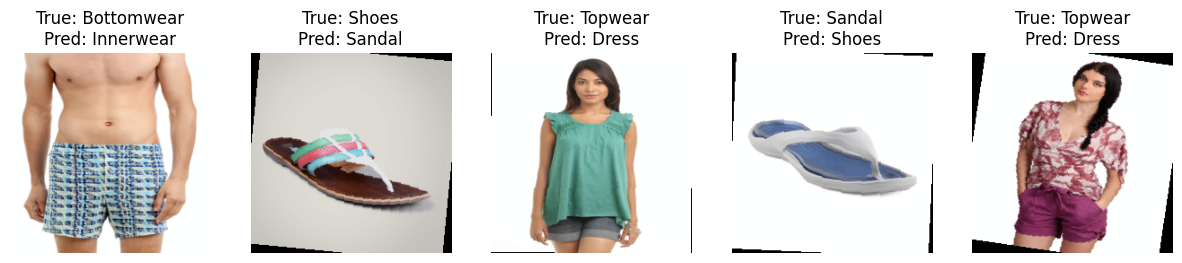

In [133]:
plot_misclassified(errors_conv, label2class)

Для трансформера

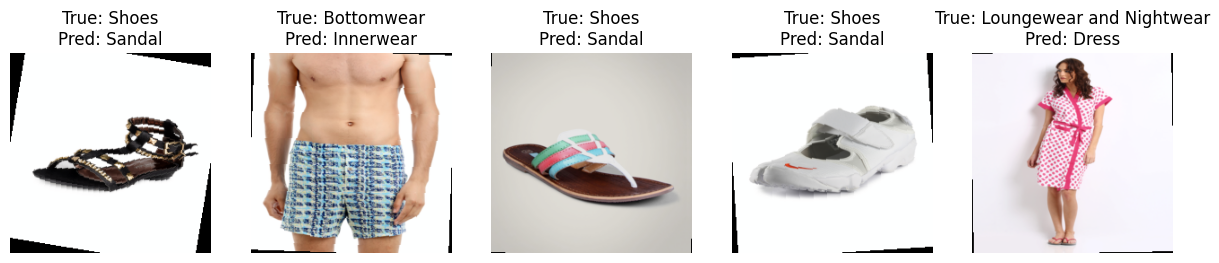

In [135]:
plot_misclassified(errors_vit, label2class)

То есть ошибки на похожих классах

3. Сделайте **выводы** по задаче.

Обе модели по итогу хорошо справились с задачей. Но я не доучил трансформер, он может дать еще большую точность

## Задача 2 &mdash; Attention vs. Outlook attention

Реализуйте классы 1 блока Attention и 1 блока Outlook attention.

Примените написанные слои к случайному тензору или произвольной картинке. Сравните:
* время вычислений (сек)
* затрачиваемую память (MB)


In [146]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Класс, реализующий Attention Block с нормализацией до линейных слоев

        :param embed_dim: размерность входа и векторов признаков attention
        :param hidden_dim: размерность скрытого слоя в FFN
                           (обычно в 2-4 раза больше embed_dim)
        :param num_heads: количество голов в Multi-Head Attention
        :param dropout: параметр FFN
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads,
                                               dropout=dropout, batch_first=False)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.FFN = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """Forward Pass для Attention Block с resid. connections"""
        inp_x = self.layer_norm_1(x)
        x = x + self.self_attn(inp_x, inp_x, inp_x)[0]
        x = x + self.FFN(self.layer_norm_2(x))
        return x

class OutlookBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(embed_dim, embed_dim, kernel_size, padding=kernel_size//2)
        self.FFN = nn.Sequential(
            nn.Conv2d(embed_dim, hidden_dim, 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, embed_dim, 1),
        )

    def forward(self, x):
        return x + self.FFN(self.conv(x))
        
def benchmark(module, input_shape, device='cuda'):
    model = module().to(device)
    input = torch.randn(input_shape).to(device)
    
    for _ in range(10):
        _ = model(input)
    
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(100):
        _ = model(input)
    torch.cuda.synchronize()
    elapsed = (time.time() - start)/100
    
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    _ = model(input)
    mem = torch.cuda.max_memory_allocated() / (1024**2)
    
    return elapsed, mem


Запуск тестов

In [148]:
embed_dim = 256
hidden_dim = 512
num_heads = 8
input_shape_attention = (256, 64, 256)
input_shape_outlook = (64, 256, 16, 16)

attention_model = lambda: AttentionBlock(embed_dim, hidden_dim, num_heads).cuda()
outlook_model = lambda: OutlookBlock(embed_dim, hidden_dim).cuda()

attn_time, attn_mem = benchmark(attention_model, input_shape_attention)
outlook_time, outlook_mem = benchmark(outlook_model, input_shape_outlook)

print(f"Attention Block | Time: {attn_time:.4f}s | Memory: {attn_mem:.2f}MB")
print(f"Outlook Block   | Time: {outlook_time:.4f}s | Memory: {outlook_mem:.2f}MB")

Attention Block | Time: 0.0103s | Memory: 2171.71MB
Outlook Block   | Time: 0.0046s | Memory: 1692.46MB


Сделайте **выводы** по задаче.

Outlook дает большую скорость и позволяет экономить память. Он нужен для работы с локальными паттернами, а Attention с глобальными